In [1]:
%matplotlib inline
import CompDoobTransform as cdt
import time
from CompDoobTransform import core
import math
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from CompDoobTransform.utils import normal_logpdf, resampling
plt.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Computing on ' + str(device))

Computing on cpu


In [2]:
data = pd.read_csv("IR3TED01USQ156N.csv")
data

,DATE,IR3TED01USQ156N
0,1999-01-01,4.933333
1,1999-04-01,4.993333
2,1999-07-01,5.400000
3,1999-10-01,6.103333
4,2000-01-01,6.063333
...,...,...
85,2020-04-01,0.503333
86,2020-07-01,0.200000
87,2020-10-01,0.193333
88,2021-01-01,0.190000


In [3]:
# tuning parameters 
d = 1
# std_obs = 0.125
std_obs = 3.0
filename = 'vasicek_var_obs_3.pt'

In [4]:
state = {}

# dimension of state 
state['dim'] = 1

# valeurs tirées du papier des données likelihood estimation
# drift of diffusion 
alpha0 = torch.tensor(0.000563, device = device) 
alpha1 = torch.tensor(-0.00673,device=device)
def drift(x):
    out = torch.zeros(x.shape)    
    out = alpha0 + alpha1 * x
    return out
a = lambda x:  drift(x)# drift
state['drift'] = a

# diffusion coefficient of diffusion

beta0 = torch.tensor(1.66e-05, device = device) 
state['sigma'] = beta0



# time interval
T = torch.tensor(1.0, device = device) 
state['terminal_time'] = T


# time-discretization settings
M = 50 # number of time steps

In [5]:
# dict for objects relating to observations
obs = {}

# dimension of observation
p = 1
obs['dim'] = p

# observation parameters
var_obs = torch.tensor(std_obs**2, device = device) # variance of observation

# log-observation density
obs_log_density = lambda x, y: normal_logpdf(y, x, var_obs) # terminal condition, returns size (N)
obs['log_density'] = obs_log_density



In [6]:
# simulate states and observations from model
X0 = torch.tensor(0.083,device= device)
X = X0.clone()
J = 2000
max_index = J*M+1
store_states = torch.zeros(J*M+1, d, device = device)
store_states[0,:] = X    
store_obs = torch.zeros(J*M, d, device = device)
stepsize = torch.tensor(T / M, device = device)
for j in range(J):
    for m in range(M):
        euler = X + stepsize * drift(X)
        W = torch.sqrt(stepsize) * torch.randn(X.shape, device = device)
        X = euler + beta0 * W
        Y = X + torch.sqrt(var_obs) * torch.randn(1, p, device = device)
        index = j*M + m + 1
        store_states[index,:] = X
        store_obs[index-1,:] = Y

# learning standardization means and standard deviations
standardization = {'x_mean': torch.mean(store_states), 
                   'x_std': torch.std(store_states), 
                   'y_mean': torch.mean(store_obs), 
                   'y_std': torch.std(store_obs)}
print(standardization)

# simulate initial states
initial = lambda N: store_states[torch.randint(0, max_index, size = (N,)), :] # function to subsample states
state['initial'] = initial

# simulate observations
observation = lambda N: initial(N) + torch.sqrt(var_obs) * torch.randn(N, p, device = device)
obs['observation'] = observation

<ipython-input-6-1458ac5c568f>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stepsize = torch.tensor(T / M, device = device)


{'x_mean': tensor(0.0836), 'x_std': tensor(0.0001), 'y_mean': tensor(0.0798), 'y_std': tensor(2.9903)}


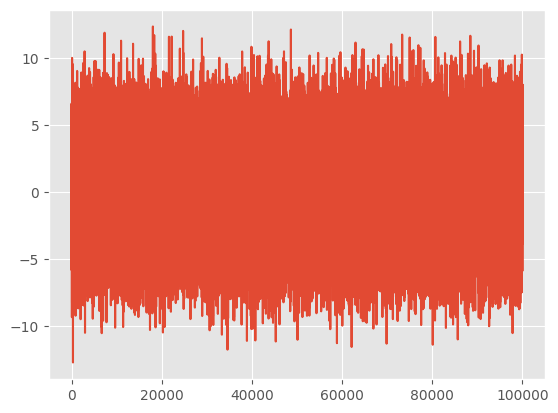

In [16]:
plt.plot(store_obs)

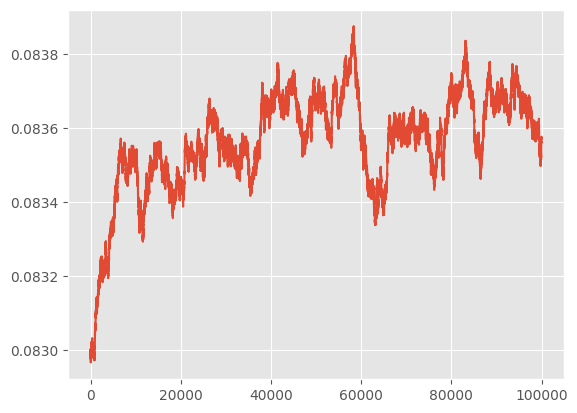

In [7]:
plt.plot(store_states.numpy())

In [8]:
# V0 and Z neural network configuration
V0_net_config = {'layers': [16], 'standardization': standardization}
Z_net_config = {'layers': [d+16], 'standardization': standardization}
net_config = {'V0': V0_net_config, 'Z': Z_net_config}

# optimization configuration (standard training)
I = 2000
optim_config = {'minibatch': 100, 
                'num_obs_per_batch': 10, 
                'num_iterations': I,
                'learning_rate' : 0.01, 
                'initial_required' : True}

In [9]:
# create model instance
model_static = cdt.core.model(state, obs, M, net_config, device = 'cpu')

# static training
time_start = time.time() 
model_static.train_standard(optim_config)
time_end = time.time()
time_elapsed = time_end - time_start
print("Training time (secs): " + str(time_elapsed))

Optimization iteration: 1 Loss: 14.173447608947754
Optimization iteration: 50 Loss: 0.33407753705978394
Optimization iteration: 100 Loss: 0.050339341163635254
Optimization iteration: 150 Loss: 0.06871674209833145
Optimization iteration: 200 Loss: 0.012985603883862495
Optimization iteration: 250 Loss: 0.030629420652985573
Optimization iteration: 300 Loss: 0.028774384409189224
Optimization iteration: 350 Loss: 0.00576928211376071
Optimization iteration: 400 Loss: 0.09936908632516861
Optimization iteration: 450 Loss: 0.00377009529620409
Optimization iteration: 500 Loss: 0.01226837933063507
Optimization iteration: 550 Loss: 0.01711113378405571
Optimization iteration: 600 Loss: 0.012457058764994144
Optimization iteration: 650 Loss: 0.06853079050779343
Optimization iteration: 700 Loss: 0.01527953427284956
Optimization iteration: 750 Loss: 0.014821176417171955
Optimization iteration: 800 Loss: 0.007329752668738365
Optimization iteration: 850 Loss: 0.0012073795078322291
Optimization iteration:

In [10]:
# create model instance
model = cdt.core.model(state, obs, M, net_config, device = 'cpu')

# iterative training
time_start = time.time() 
model.train_iterative(optim_config)
time_end = time.time()
time_elapsed = time_end - time_start
print("Training time (secs): " + str(time_elapsed))

Optimization iteration: 1 Loss: 9.294490814208984
Optimization iteration: 50 Loss: 0.31726035475730896
Optimization iteration: 100 Loss: 0.021847009658813477
Optimization iteration: 150 Loss: 0.007195449434220791
Optimization iteration: 200 Loss: 0.004200720228254795
Optimization iteration: 250 Loss: 0.019038056954741478
Optimization iteration: 300 Loss: 0.0018621878698468208
Optimization iteration: 350 Loss: 0.005607950501143932
Optimization iteration: 400 Loss: 0.0038732532411813736
Optimization iteration: 450 Loss: 0.008692060597240925
Optimization iteration: 500 Loss: 0.0018018491100519896
Optimization iteration: 550 Loss: 0.02315254509449005
Optimization iteration: 600 Loss: 0.004607255570590496
Optimization iteration: 650 Loss: 0.0011165831238031387
Optimization iteration: 700 Loss: 0.0015406603924930096
Optimization iteration: 750 Loss: 0.0005693084676750004
Optimization iteration: 800 Loss: 0.02004164457321167
Optimization iteration: 850 Loss: 0.08175957947969437
Optimization i

In [11]:
# repeat particle filters
multiplier = 1.0
num_obs = [100, 200, 400, 800]
len_num_obs = len(num_obs)
num_particles = [2**6, 2**7, 2**8, 2**9]
R = 20 # number of repeats


APFF = {'ess' : torch.zeros(len_num_obs, R), 'log_estimate' : torch.zeros(len_num_obs, R)}
BPF = {'ess' : torch.zeros(len_num_obs, R), 'log_estimate' : torch.zeros(len_num_obs, R)}

In [12]:

for i in range(len_num_obs):
    # number of observations
    K = num_obs[i]

    # number of particles
    N = num_particles[i]

    # simulate latent process and observations
    X0 = torch.ones(1,d)
    X = torch.zeros(K+1, d)
    X[0,:] = X0.clone()
    Y = torch.zeros(K, p)
    for k in range(K):
        X[k+1,:] = model.simulate_diffusion(X[k,:].reshape((1,d)))
        Y[k,:] = X[k+1,:] + multiplier * torch.sqrt(var_obs) * torch.randn(1,p)

    for r in range(R):
        # run particle filters
        BPF_output = model.run_BPF(X0.repeat((N,1)), Y, N)
        APFF_output = model_static.run_APF(X0.repeat((N,1)), Y, N)

        # save average ESS%
        BPF_ESS = torch.mean(BPF_output['ess'] * 100 / N)
        APFF_ESS = torch.mean(APFF_output['ess'] * 100 / N)
        BPF['ess'][i,r] = BPF_ESS
        APFF['ess'][i,r] = APFF_ESS

        # save log-likelihood estimates
        BPF_log_estimate = BPF_output['log_norm_const'][-1]
        APFF_log_estimate = APFF_output['log_norm_const'][-1]
        BPF['log_estimate'][i,r] = BPF_log_estimate
        APFF['log_estimate'][i,r] = APFF_log_estimate

        # print output
        print('No. of observations: ' + str(K) + ' Repeat: ' + str(r)) 
        print('BPF ESS%: ' + str(BPF_ESS))
        print('APFF ESS%: ' + str(APFF_ESS)) 
        print('BPF log-estimate: ' + str(BPF_log_estimate))
        print('APFF log-estimate: ' + str(APFF_log_estimate))

# save results
results = {'BPF' : BPF, 'APFF' : APFF}
torch.save(results, filename)

No. of observations: 100 Repeat: 0
BPF ESS%: tensor(100.)
APFF ESS%: tensor(2.5460)
BPF log-estimate: tensor(-253.7139)
APFF log-estimate: tensor(-1720966.)
No. of observations: 100 Repeat: 1
BPF ESS%: tensor(100.)
APFF ESS%: tensor(2.6113)
BPF log-estimate: tensor(-253.7138)
APFF log-estimate: tensor(-1722012.6250)
No. of observations: 100 Repeat: 2
BPF ESS%: tensor(100.)
APFF ESS%: tensor(2.5401)
BPF log-estimate: tensor(-253.7137)
APFF log-estimate: tensor(-1719511.8750)
No. of observations: 100 Repeat: 3
BPF ESS%: tensor(100.)
APFF ESS%: tensor(2.5958)
BPF log-estimate: tensor(-253.7138)
APFF log-estimate: tensor(-1722627.2500)
No. of observations: 100 Repeat: 4
BPF ESS%: tensor(100.)
APFF ESS%: tensor(2.5591)
BPF log-estimate: tensor(-253.7135)
APFF log-estimate: tensor(-1720994.5000)
No. of observations: 100 Repeat: 5
BPF ESS%: tensor(100.)
APFF ESS%: tensor(2.5492)
BPF log-estimate: tensor(-253.7136)
APFF log-estimate: tensor(-1720750.1250)
No. of observations: 100 Repeat: 6
BPF

In [13]:
BPF["ess"]

tensor([[100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100.],
        [100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100.],
        [100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100.],
        [100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100.]])

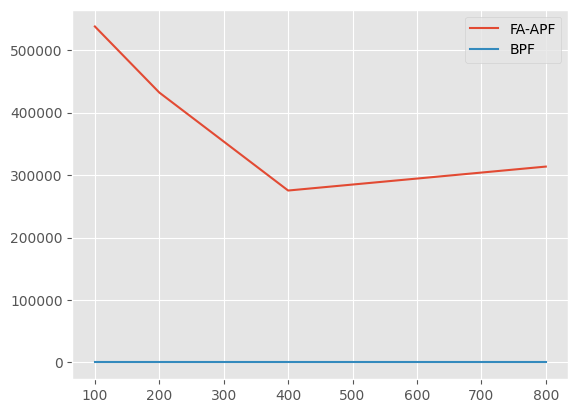

In [14]:
plt.plot(num_obs,APFF["log_estimate"].var(1))
plt.plot(num_obs,BPF["log_estimate"].var(1))
plt.legend(["FA-APF","BPF"])
plt.show()